# Caso práctico: Random Forest

En este caso de uso práctico se pretende resolver un problema de detección de Malware en dispositivos 
Android mediante el análisis del tráfico de red que genera el dispositivo mediante el uso de subconkjuntos 
de arbloes de decisión.

### DataSet: Detección del Malware en Android

#### Descripción
The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behaviour to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. 

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1,900 applications with the following three categories:

1. Adware (250 apps)
Airpush: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.

Dowgin: Designed as an advertisement library that can also steal the user’s information.

Kemoge: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.

Mobidash: Designed to display ads and to compromise user’s personal information.

Shuanet: Similar to Kemoge, Shuanet is also designed to take over a user’s device.

2. General Malware (150 apps)
AVpass: Designed to be distributed in the guise of a Clock app.

FakeAV: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.

FakeFlash/FakePlayer: Designed as a fake Flash app in order to direct users to a website (after successfully installed).

GGtracker: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.

Penetho: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via infected email attachment, fake updates, external media and infected documents.

3. Benign (1,500 apps)
2015 GooglePlay market (top free popular and top free new)

2016 GooglePlay market (top free popular and top free new)

License
The CICAAGM dataset consists of the following items is publicly available for researchers.

.pcap files – the network traffic of both the malware and benign (20% malware and 80% benign)

.csv files - the list of extracted network traffic features generated by the CIC-flowmeter

If you are using our dataset, you should cite our related paper that outlines the details of the dataset and its underlying principles:

Arash Habibi Lashkari, Andi Fitriah A. Kadir, Hugo Gonzalez, Kenneth Fon Mbah and Ali A. Ghorbani, “Towards a Network-Based Framework for Android Malware Detection and Characterization”, In the proceeding of the 15th International Conference on Privacy, Security and Trust, PST, Calgary, Canada, 2017.


# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from pandas import DataFrame

## Funciones auxiliares

In [ ]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state = rstate, shuffle=shuffle, stratify=strat)
    strat = train_test[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state = rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [ ]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return(X, y)

In [ ]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average="weighted"))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_pred, average="weighted")) 

## 1.- Lectura del DataSet

In [ ]:
df = pd.read_csv('TotalFeatures-ISCXFlowMeter.csv')

## 2.- Visualizacion del DataSet

In [ ]:
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [ ]:
df.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,6.319550e+05,631955.000000,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.000000,631955.000000,631955.000000,631955.000000,...,6.319550e+05,6.319550e+05,6.319550e+05,6.319550e+05,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.00000,631955.000000
mean,2.195245e+07,6.728514,10.431934,9.540172e+02,1.206042e+04,141.475727,44.357688,263.675901,183.248084,174.959706,...,1.997327e+07,2.031228e+07,2.075238e+07,4.663875e+05,2.360896,9.620796e+05,3.104519e+05,9.733144,6.72471,19.965713
std,1.900578e+08,174.161354,349.424019,8.235040e+04,4.824716e+05,157.680880,89.099554,289.644383,371.863224,162.024811,...,1.897986e+08,1.897902e+08,1.899721e+08,6.199704e+06,3.041810,1.705655e+06,6.647956e+05,347.877923,174.13813,14.914261
min,-1.800000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,-1.000000e+00,-1.000000e+00,0.000000,0.00000,0.000000
25%,0.000000e+00,1.000000,0.000000,6.900000e+01,0.000000e+00,52.000000,-1.000000,52.000000,-1.000000,52.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.00000,0.000000
50%,2.445000e+04,1.000000,0.000000,1.840000e+02,0.000000e+00,52.000000,-1.000000,83.000000,-1.000000,83.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,8.761600e+04,-1.000000e+00,0.000000,1.00000,32.000000
75%,1.759751e+06,3.000000,1.000000,4.270000e+02,1.670000e+02,108.000000,52.000000,421.000000,115.000000,356.000000,...,1.013498e+06,1.291379e+06,1.306116e+06,0.000000e+00,2.000000,3.046400e+05,9.049600e+04,1.000000,3.00000,32.000000
max,4.431076e+10,48255.000000,74768.000000,4.049644e+07,1.039222e+08,1390.000000,1390.000000,1500.000000,1390.000000,1390.000000,...,4.431072e+10,4.430000e+10,4.431072e+10,8.470000e+08,2269.000000,4.194240e+06,4.194240e+06,74524.000000,48255.00000,44.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631955 entries, 0 to 631954
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 631955 non-null  int64  
 1   total_fpackets           631955 non-null  int64  
 2   total_bpackets           631955 non-null  int64  
 3   total_fpktl              631955 non-null  int64  
 4   total_bpktl              631955 non-null  int64  
 5   min_fpktl                631955 non-null  int64  
 6   min_bpktl                631955 non-null  int64  
 7   max_fpktl                631955 non-null  int64  
 8   max_bpktl                631955 non-null  int64  
 9   mean_fpktl               631955 non-null  float64
 10  mean_bpktl               631955 non-null  float64
 11  std_fpktl                631955 non-null  float64
 12  std_bpktl                631955 non-null  float64
 13  total_fiat               631955 non-null  int64  
 14  tota

In [ ]:
print("Longitud del DataSet:", len(df))
print("Número de caracteristicas del DataSet:", len(df.columns))

Longitud del DataSet: 631955
Número de caracteristicas del DataSet: 80


In [ ]:
df["calss"].value_counts()

calss
benign            471597
asware            155613
GeneralMalware      4745
Name: count, dtype: int64

#### Buscando correlaciones 

In [ ]:
# Tranformamos la variable de salida a númerica para calcular correlaciones
X = df.copy()
X['calss'] = X['calss'].factorize()[0]

In [ ]:
# Calculamos las correlaciones
corr_matrix = X.corr()
corr_matrix["calss"].sort_values(ascending = False)

calss                     1.000000
flow_fin                  0.286175
min_seg_size_forward      0.258352
Init_Win_bytes_forward    0.129425
std_fpktl                 0.123758
                            ...   
furg_cnt                       NaN
burg_cnt                       NaN
flow_urg                       NaN
flow_cwr                       NaN
flow_ece                       NaN
Name: calss, Length: 80, dtype: float64

In [ ]:
X.corr()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
total_fpackets,0.004837,1.000000,0.924622,0.425756,0.904007,-0.018958,0.005252,0.024685,0.086255,-0.007910,...,0.001614,0.002267,0.017229,0.016089,0.050201,0.059224,0.902713,0.999866,0.018198,0.018377
total_bpackets,0.004011,0.924622,1.000000,0.156780,0.997268,-0.017667,0.006912,0.018170,0.086886,-0.016104,...,0.000922,0.001617,0.016230,-0.000493,0.048190,0.058435,0.997580,0.924746,0.015124,0.019430
total_fpktl,0.001673,0.425756,0.156780,1.000000,0.090082,-0.003099,0.000803,0.021278,0.022088,0.022409,...,0.000335,0.000609,0.009896,0.001657,0.013283,0.015991,0.088422,0.425789,0.005477,0.000679
total_bpktl,0.003518,0.904007,0.997268,0.090082,1.000000,-0.014926,0.005966,0.012560,0.079905,-0.017328,...,0.000812,0.001452,0.014336,-0.000293,0.043571,0.053134,0.999616,0.904129,0.012139,0.019838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Init_Win_bytes_backward,0.029712,0.059224,0.058435,0.015991,0.053134,-0.268444,0.038319,0.429893,0.593143,-0.030004,...,0.026959,0.029512,0.097316,-0.052507,0.811204,1.000000,0.056761,0.059242,0.333701,0.069405
RRT_samples_clnt,0.003785,0.902713,0.997580,0.088422,0.999616,-0.016659,0.006156,0.015727,0.084280,-0.017595,...,0.000893,0.001560,0.015200,-0.000437,0.046784,0.056761,1.000000,0.902834,0.014299,0.019679
Act_data_pkt_forward,0.004838,0.999866,0.924746,0.425789,0.904129,-0.018947,0.005264,0.024705,0.086278,-0.007893,...,0.001617,0.002269,0.017233,0.000734,0.050220,0.059242,0.902834,1.000000,0.018229,0.018391
min_seg_size_forward,0.082955,0.018198,0.015124,0.005477,0.012139,-0.686154,-0.189824,-0.074763,0.217989,-0.524024,...,0.077943,0.079324,0.048803,0.052177,0.394743,0.333701,0.014299,0.018229,1.000000,0.258352


In [ ]:
# Se puede llegar a valorar y quedarnos con aquellas que tengan mayor correlación
corr_matrix[corr_matrix['calss']> 0.05]

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
max_bpktl,0.042925,0.086255,0.086886,0.022088,0.079905,-0.277317,0.275923,0.492194,1.000000,-0.018358,...,0.035413,0.038732,0.127548,-0.044916,0.586742,0.593143,0.084280,0.086278,0.217989,0.073212
mean_bpktl,0.025117,0.139142,0.151761,0.018954,0.146437,-0.280648,0.465208,0.342392,0.895712,-0.096195,...,0.018533,0.021519,0.114949,-0.045442,0.452735,0.478823,0.150252,0.139172,0.122226,0.064753
std_fpktl,0.039350,0.010172,0.002331,0.011416,-0.003162,-0.245792,0.052877,0.817873,0.564243,0.259588,...,0.031418,0.033978,0.096844,-0.020885,0.558249,0.532900,0.000140,0.010182,0.301237,0.123758
std_bpktl,0.048743,0.020324,0.014005,0.007763,0.007768,-0.225143,0.035371,0.534532,0.941626,0.051756,...,0.042562,0.045450,0.113854,-0.033991,0.594790,0.577954,0.012050,0.020335,0.276055,0.072953
total_fiat,0.943898,0.002190,0.001718,0.000708,0.001546,-0.049879,-0.031218,-0.029233,-0.005961,-0.048869,...,0.943668,0.943339,0.015254,0.020302,-0.011637,-0.016421,0.001615,0.002190,0.065124,0.064770
min_fiat,0.841692,-0.001975,-0.002172,-0.000746,-0.001820,-0.040046,-0.036619,-0.052289,-0.035963,-0.053811,...,0.843330,0.842512,-0.005389,0.015316,-0.027350,-0.033944,-0.002037,-0.001974,0.051853,0.074491
max_fiat,0.943438,-0.000420,-0.000714,-0.000389,-0.000548,-0.046977,-0.032630,-0.032606,-0.009878,-0.049032,...,0.944412,0.943971,0.012557,0.017756,-0.012317,-0.016206,-0.000644,-0.000418,0.061285,0.064875
mean_fiat,0.918036,-0.001970,-0.002241,-0.000728,-0.001907,-0.042455,-0.036056,-0.048712,-0.032412,-0.052892,...,0.919653,0.918797,-0.003523,0.016958,-0.025823,-0.032466,-0.002113,-0.001968,0.055151,0.071397
std_flowpktl,0.036942,0.087741,0.087307,0.024298,0.080666,-0.262968,0.338513,0.631466,0.911584,0.095976,...,0.030013,0.033100,0.120257,-0.035737,0.580266,0.586355,0.084725,0.087764,0.219346,0.119375


## 3.- División del DataSet

In [ ]:
# Dividir el DataSet
train_set, val_set, test_set = train_val_test_split(df)

In [ ]:
X_train, y_train = remove_labels(train_set, 'calss')
X_val , y_val = remove_labels(val_set, 'calss')
X_test, y_test = remove_labels(test_set, 'calss')

## 4.- Escalado del DataSet
Es importante comprender que los árboles de decisión son algoritmos que **no requieren demasiada preparación de los datos **
correctamente, no requieren la realización o escalado o normalización. En este ejercicio se va a realizar escalado al DataSet
y van a comparar los resultados con el DataSet sin escalar.
De esta manera se demuestra como aplicar preprocesamientos como el escalado puede llegar a afectar el rendimiento del modelo

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val)

In [ ]:
# Realizar la transformación a un DataFrame de Pandas
X_train_scaled = DataFrame(X_train_scaled, columns = X_train.columns, index=X_train.index)
X_train_scaled.head(5)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
508881,-0.013646,0.0,1.0,-0.310056,1.556886,0.375000,4.924528,-0.027100,2.250000,-0.032895,...,0.0,0.0,0.0,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
208326,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.0,0.0,0.0,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
107213,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.0,0.0,0.0,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
466726,-0.000273,0.0,1.0,-0.363128,2.724551,0.035714,8.603774,-0.078591,3.931034,-0.095395,...,0.0,0.0,0.0,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
230085,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.0,0.0,0.0,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0


## Decisión Forest 

In [ ]:
print("f1 Score Train Set: ", f1_score(y_train_pred, y_train, average="weighted"))

f1 Score Train Set:  0.9812485491275494


In [ ]:
# Predecir con el DataSet de Validación
y_val_pred = clf_tree.predict(X_val)

In [ ]:
# Comparar resultados entre el escalado y sin escalar
print("F1 Score Validation Set: ", f1_score(y_val_pred, y_val, average="weighted"))

F1 Score Validation Set:  0.9300607874722845


## 6.- Random Forest 

In [ ]:
from sklearn. ensemble import RandomForestClassifier

# Modelo entrenado con el DataSet sin escalar 
clf_rnd = RandomForestClassifier(n_estimators=100, random_state = 42, n_jobs = -1)
clf_rnd.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Modelo entrenado con el DataSet sin escalar 
clf_rnd_scaled = RandomForestClassifier(n_estimators=100, random_state = 42, n_jobs = -1)
clf_rnd_scaled.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Predecir con el DataSet de entrenamiento 
y_train_pred = clf_rnd.predict(X_train)
y_train_prep_pred = clf_rnd_scaled.predict(X_train_scaled)

In [ ]:
# Comparar resultados entre el escalado y  sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 0.9812539390548333
f1_score WITH preparation: 0.9999393406486808


## 7.- Regresion Forest


Los arboles y conjuntos de arboles de decision tambien pueden aplicarse a problemas de regresion

In [ ]:
# Importamos las librerías requeridas
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
# Creamos un conjunto de datos de ejemplo
np.random.seed(42)
X = np.random.rand(100, 1) * 10   # Variable independiente
y = 2.5 * X.flatten() + np.random.randn(100) * 2   # Variable dependiente con ruido


In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Creamos el modelo de Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,        # Número de árboles
    random_state=42,
    max_depth=None,          # Sin límite de profundidad
    min_samples_split=2,     # Mínimo de muestras para dividir un nodo
    min_samples_leaf=1       # Mínimo de muestras en una hoja
)

# Entrenamos el modelo
rf_regressor.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Predicciones con el conjunto de prueba
y_pred = rf_regressor.predict(X_test)


In [ ]:
# Calculamos métricas de desempeño
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Métricas del modelo Random Forest Regressor:")
print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")


Métricas del modelo Random Forest Regressor:
Error cuadrático medio (MSE): 3.00
Raíz del error cuadrático medio (RMSE): 1.73
Coeficiente de determinación (R²): 0.95


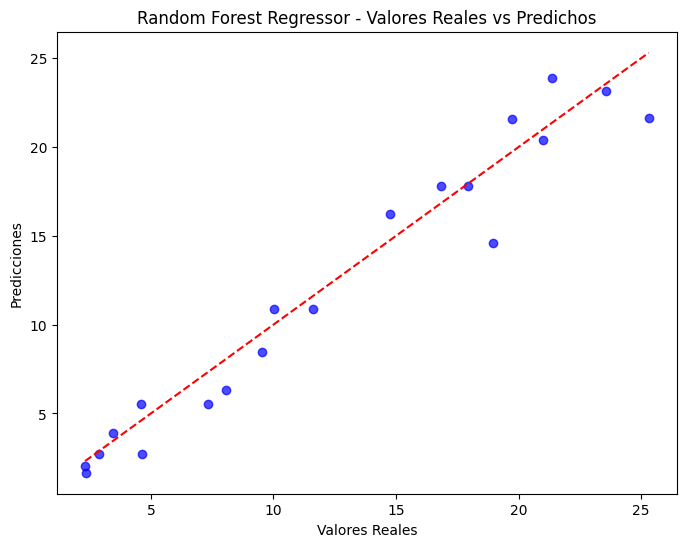

In [ ]:
# Graficamos valores reales vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Random Forest Regressor - Valores Reales vs Predichos")
plt.show()
